# PHYS 6260: Homework 6, Michael Haynes
_Note: when possible, I will try to maximize the speedup from distributed computing. However, due to python's [thread locking mutex](https://wiki.python.org/moin/GlobalInterpreterLock), it is unlikely to boost performance when in the multithreading regime. I will therefore try not to surpass the number of processors housed in the machine on which I finish this assignment (when not already specified by the prompt)._

In [1]:
## import the generics
import numpy as np
from numpy.random import random
import matplotlib.pyplot as plt
import math as m
import time as time

## Problem 1: Parallel Monte Carlo Solver
### The Nuclear Decay Equation
The $^8\mathrm{Li}$ isotope is unstable and has a half life $\tau_{1/2} = 838.73 \cdot 10^{-3} \,\mathrm{s}$. The $\beta^-$ decay of $^8\mathrm{Li}$ converts a neutron in the atom's nucleus to a proton and electron (with an anti-neutrino), yielding $^8\mathrm{Be}$. The decay rate of this isotope can be represented by a simple analytical form. For a $^8\mathrm{Li}$ population of number $N$, the conversion of one species to the other follows
$$ \frac{\mathrm{d}N}{\mathrm{d}t} = -\lambda N = -\frac{\log{(2)} N}{\tau_{1/2}} \qquad .$$
Direct integration yields
$$ N(t) = N_0 e^{-\lambda t} \qquad .$$  
We will model this process by using a Monte Carlo method. This consists of generating random numbers on the unit interval and comparing them to probabilities in order to evaluate random processes. These direct simulations provide an ability to learn the governing behavior while also adding complexity beyond the (sometimes) simple, smooth analytical solution. This method is thus used frequently in modeling atomic or nuclear processes, such as this. 
#### Part (a): Write a function to model the decay of $^8\mathrm{Li}$
_Note: we use the code provided in the file 08_decay0.py on Canvas as a starter template for this function_

In [2]:

def NucDecay(Ns1,Ns2,tau,tmax,NUM):
    tpoints = np.linspace(start=0.0,stop=tmax,num=NUM)
    h = tpoints[1] - tpoints[0]
    
    # initialize probability of single transition
    p = 1 - 2**(-h/tau)   # Probability of decay in one step

    # Lists of plot points
    S1points = []
    S2points = []
    
    # Main loop
    for n,t in enumerate(tpoints):
        S1points.append(Ns1)
        S2points.append(Ns2)

        # Calculate the number of decayed atoms in each timestep h
        rand_arr = np.random.random(S1points[n])
        new_s2 = (rand_arr < p).sum()
        
        Ns1 -= new_s2
        Ns2 += new_s2

    return tpoints,S1points,S2points


Ns1 = 1000            # Number of species 1 atoms (the species undergoing decay, in this case, Li)
Ns2 = 0               # Number of species 2 atoms (the daughter isotope)
tau = 838.7e-03       # Half life of species 1 in seconds
tmax = 1              # Total time
NUM = 1000


tpoints, S1points, S2points = NucDecay(Ns1,Ns2,tau,tmax,NUM)


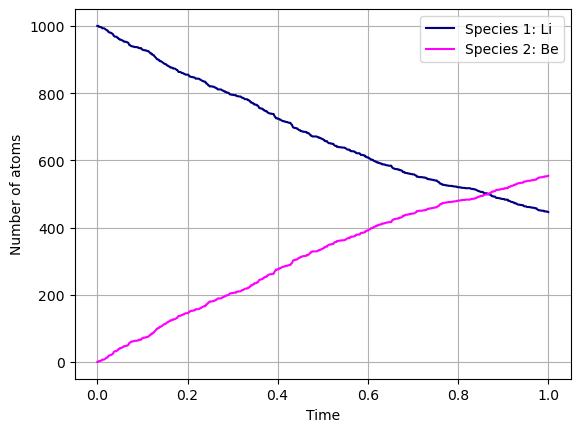

In [3]:
    
# Simple plot routine
plt.plot(tpoints,S1points, color='navy',label='Species 1: Li')
plt.plot(tpoints,S2points, color='magenta', label='Species 2: Be')
plt.xlabel("Time")
plt.ylabel("Number of atoms")
plt.grid()
plt.legend()


plt.show()

#### Part (b): Evaluate the function from part (a) ten times, and determine the computing resources needed

time elapsed: 0.0921 seconds


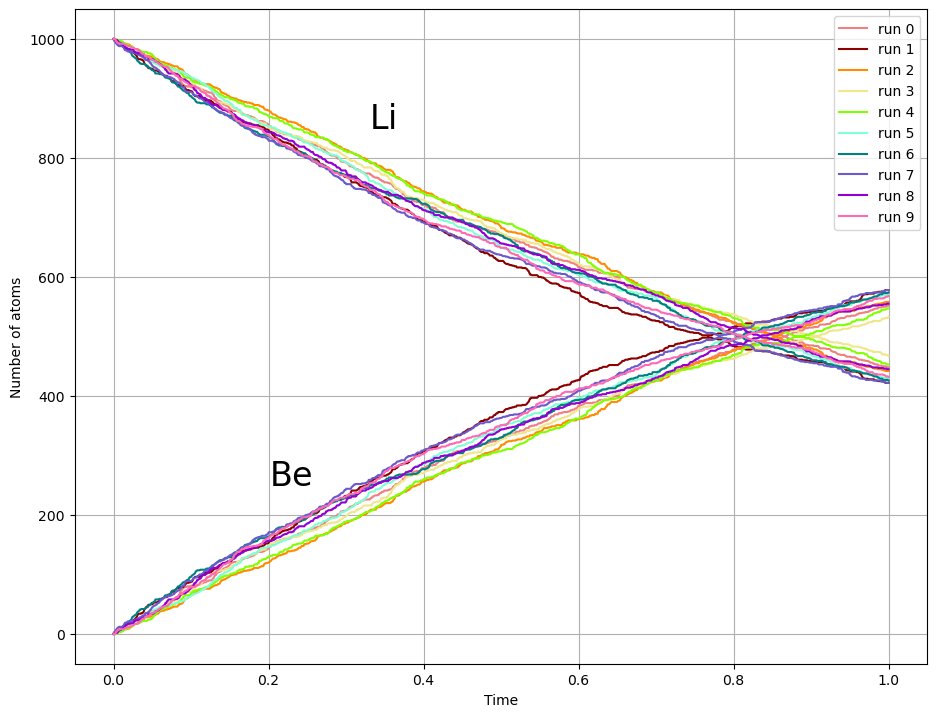

In [4]:
t_start = time.time()

num_runs = 10
S1_arrs = []
S2_arrs = []

# loop over 10 different function calls. Since no seed is explicitly given, each call is inherently a new sample
for i in range(num_runs):
    tpoints, S1points, S2points = NucDecay(Ns1,Ns2,tau,tmax,NUM)
    S1_arrs.append(S1points)
    S2_arrs.append(S2points)

# perform timing analysis
t_stop = time.time()
tdel = round(t_stop-t_start,4)
print("time elapsed: "+str(tdel)+" seconds")

# define 10 spaced colors to display each pair on top of each other
colors = ['lightcoral', 'darkred', 'darkorange', 'khaki', 'chartreuse', 'aquamarine', 'teal', 'slateblue','darkviolet','hotpink']

# loop over arrays generated above (inside timer) to display results
fig, ax = plt.subplots(figsize=(11,8.5))
for i in range(num_runs):
    Lab = 'run '+str(i)
    plt.plot(tpoints,S1_arrs[i],color=colors[i],label=Lab)
    plt.plot(tpoints,S2_arrs[i],color=colors[i])
# plot everything
plt.xlabel("Time")
plt.ylabel("Number of atoms")
ax.text(0.2,250,r'$ \mathrm{Be}$',fontsize=24)
ax.text(0.33,850,r'$ \mathrm{Li}$',fontsize=24)
plt.grid()
plt.legend()
plt.show()

#### Part (c): Use the Multiprocessing module to parallelize the code from part (b)

In [5]:
# to avoid errors running multiprocessing.pool() class on Jupyter lab, I use the dill-managed multiprocess package (equivalent to multiprocessing in all other regards)
import multiprocess as multiprocessing
import os

In [6]:
# define modified function from part (a) that changes the data structure passed in, so that the multiple arguments can be passed via "pool"
def NucDecayMulti(array_args):
    Ns1 = array_args[0]
    Ns2 = array_args[1]
    tau = array_args[2]
    tmax = array_args[3]
    NUM = array_args[4]

    np.random.seed()
    
    tpoints = np.linspace(start=0.0,stop=tmax,num=NUM)
    h = tpoints[1] - tpoints[0]
    
    # initialize probability of single transition
    p = 1 - 2**(-h/tau)   # Probability of decay in one step

    # Lists of plot points
    S1points = []
    S2points = []
    
    # Main loop
    for n,t in enumerate(tpoints):
        S1points.append(Ns1)
        S2points.append(Ns2)

        # Calculate the number of decayed atoms in each timestep h
        rand_arr = np.random.random(S1points[n])
        new_s2 = (rand_arr < p).sum()
        
        Ns1 -= new_s2
        Ns2 += new_s2

    return tpoints,S1points,S2points

a_arr = [Ns1,Ns2,tau,tmax,NUM]

tpoints, S1Mfunc, S2Mfunc = NucDecayMulti(a_arr)


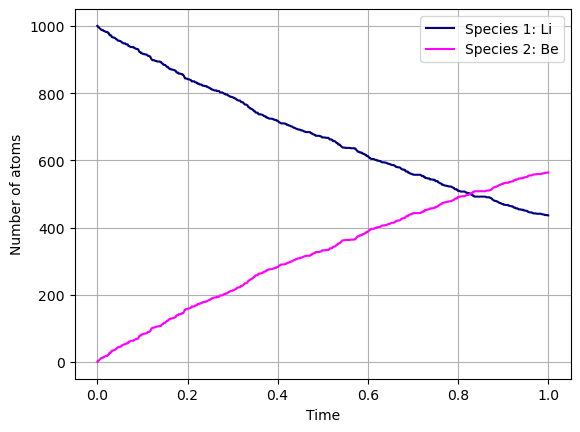

In [7]:
# Simple plot routine to verify the new function produces the same/expected result
plt.plot(tpoints,S1Mfunc, color='navy',label='Species 1: Li')
plt.plot(tpoints,S2Mfunc, color='magenta', label='Species 2: Be')
plt.xlabel("Time")
plt.ylabel("Number of atoms")
plt.grid()
plt.legend()


plt.show()

In [8]:
# define vars like number of processors used, and the args to pass to the function in each instance
# My desktop at home only has 4 procs, but the time here minimizes at 6..
nprocs = 6
numRuns = 10
args_arr = []
for i in range(numRuns):
    args_arr.append(a_arr)

# start clock for parallel stuff
time0 = time.time()
pool = multiprocessing.Pool(processes=nprocs)

result = pool.map(NucDecayMulti, args_arr)
timeE = time.time()
tdel2 = round(timeE-time0,4)
print("time elapsed: "+str(tdel2)+" seconds")

time elapsed: 0.2337 seconds


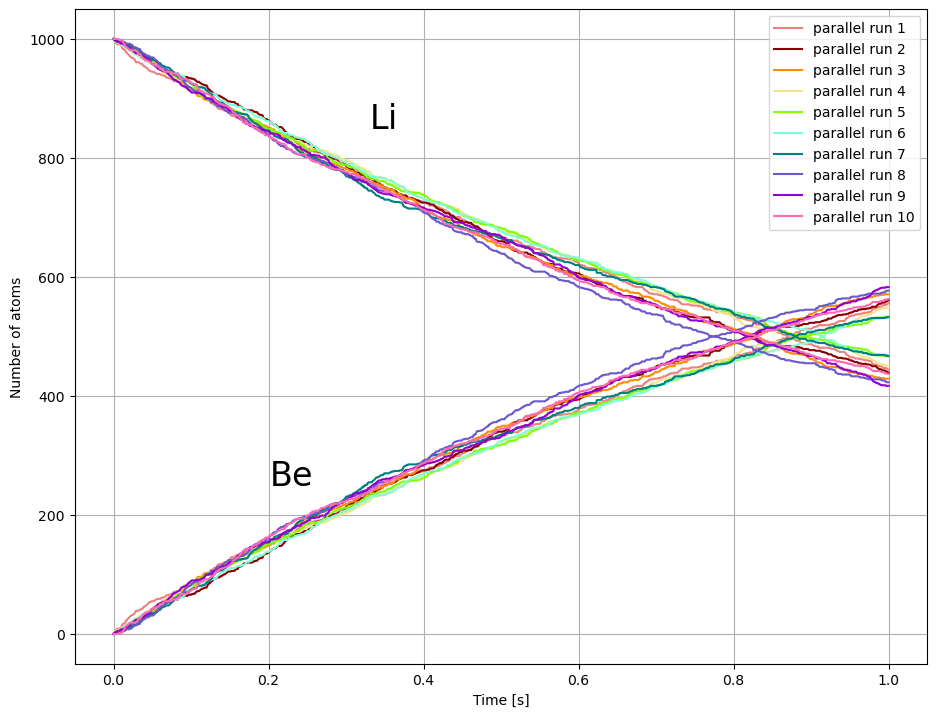

In [9]:
# plot the output
fig, ax = plt.subplots(figsize=(11,8.5))
# loop over outputs (thankfully we chose as many processors as we have colors)
for i in range(numRuns):
    times = result[i][0][:]
    ns1 = result[i][1][:]
    ns2 = result[i][2][:]
    lab = 'parallel run '+str(i+1)
    plt.plot(times,ns1,colors[i],label=lab)
    plt.plot(times,ns2,colors[i])
plt.xlabel("Time [s]")
plt.ylabel("Number of atoms")
plt.grid()
plt.legend()
ax.text(0.2,250,r'$ \mathrm{Be}$',fontsize=24)
ax.text(0.33,850,r'$ \mathrm{Li}$',fontsize=24)
plt.show()

## Problem 2 (run and include as script)
See HW6-Nbody0.py for a serial version to parallelize.

#### Parts (a), (b), and (c) are completed and included in the file Nbody0-vfinal.py
#### Part (c) asks to include the final position plot and a plot of performance metrics:
In this notebook below, include your particle position plot at the final time and your parallel efficiency code and plot here.

![Position ($t=5,000\,\mathrm{s}$)](positions-0500.png)

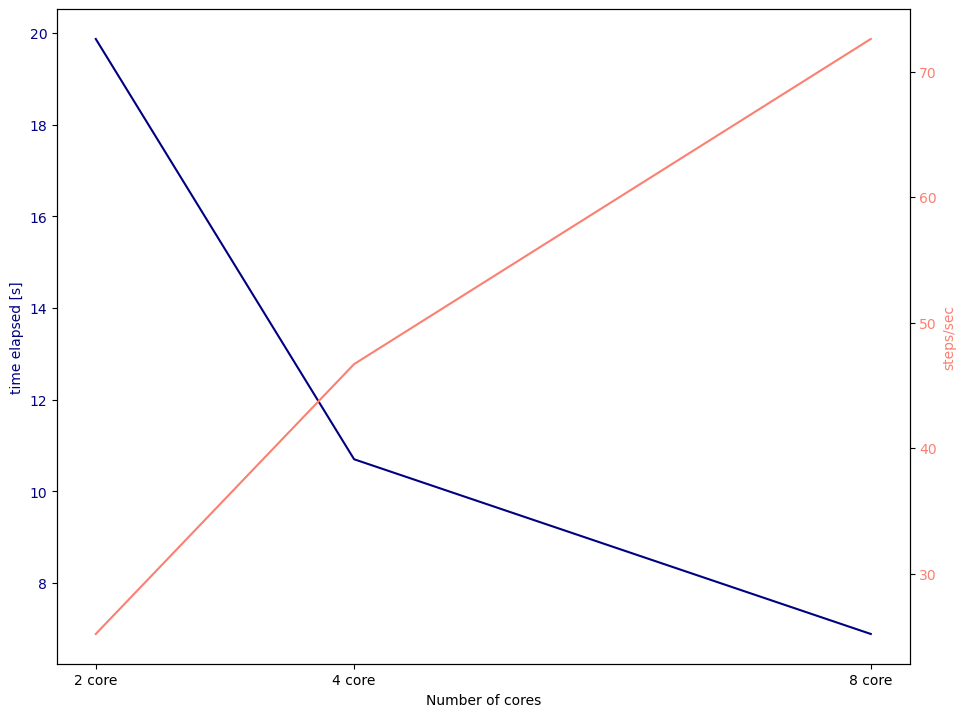

In [23]:
# assign performance data as recorded, then plot:
# 2 core: Compute time elapsed = 19.866 seconds (25.2 steps/sec // 2.52e+04 particle-evolve/sec)
# 4 core: Compute time elapsed = 10.700 seconds (46.7 steps/sec // 4.67e+04 particle-evolve/sec)
# 8 core: Compute time elapsed = 6.890 seconds (72.6 steps/sec // 7.26e+04 particle-evolve/sec)
# load data
info_names = ['2 core', '4 core', '8 core']
info_tags = [2.,4.,8.]
info_vals = np.array([np.array([19.866,25.2,2.52e+04]),np.array([10.7,46.7,4.67e+04]),np.array([6.89,72.6,7.26e+04])])
# assign to different vars reported
time_elapsed = info_vals[:,0]
steps_per_sec = info_vals[:,1]
particles_per_sec = info_vals[:,2]

# plot
## Note: since steps/sec and particles/sec only differ by the factor of N_total = 1000, we only show steps/sec here- the plots have the same form.
fig, ax1 = plt.subplots(figsize=(11,8.5))
ax1.set_xlabel('Number of cores')
ax1.set_ylabel('time elapsed [s]', color='navy')
ax1.plot(info_tags, time_elapsed, color='navy')
ax1.tick_params(axis='y', labelcolor='navy')
plt.xticks(info_tags, labels=info_names)

ax2 = ax1.twinx()
ax2.set_ylabel('steps/sec', color='salmon')
ax2.plot(info_tags, steps_per_sec, color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')

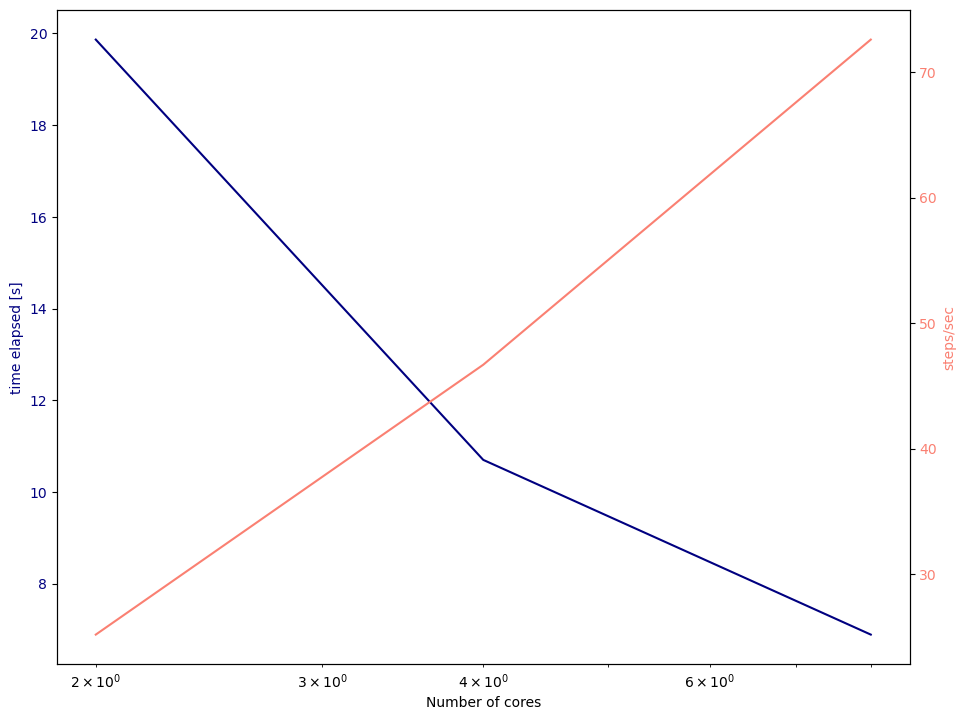

In [24]:
# same plot, with logscale
fig, ax1 = plt.subplots(figsize=(11,8.5))
ax1.set_xlabel('Number of cores')
ax1.set_ylabel('time elapsed [s]', color='navy')
ax1.semilogx(info_tags, time_elapsed, color='navy')
ax1.tick_params(axis='y', labelcolor='navy')
plt.xticks(info_tags, labels=info_names)

ax2 = ax1.twinx()
ax2.set_ylabel('steps/sec', color='salmon')
ax2.semilogx(info_tags, steps_per_sec, color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')

#### Part (d): From inspecting the performance increases in part (c) and the nature of the algorithm(s), is it worthwhile to parallelize the other parts of the code?
Unless the particle size grew extremely large (likely $\geq10^8$ or so), it would probably not be worth the communication / developmental overhead to distribute the computations in any other substep of this program. It appears that we already saw diminishing returns increasing above 4 cores, so I would not expect parallelization to substantially improve the efficiency of any other aspect. The main repeated element of this code is the leapfrog solver, specifically calling the $\verb|calc_accel|$ routine. If the particle size were to grow enormous, then the distribution would have to be reconsidered: I would likely include a parallel routine for the initialization simulteneously across processors, and I would also distribute the other calculations under the hood of the leapfrog algorithm. However, since the main bottleneck is summing the force on each particle over every other particle, this is the only routine that currently _needs_ to be parallelized.

## Problem 3: Application Question

I have always been interested in orbital dynamics, the time dependent system of a certain $n$ bodies orbiting about some center of mass. The distinction between the system studied in problem (2) and the systems I am interested in largely are due to the nature of the initial conditions: rather than accretion / coalescence from relatively quiescient initial conditions, I am keen to study the dynamics of a 3+ body orbital problem with substantive initial velocities for the bodies. The stable orbits produced by such configurations are quite fascinating, and can lead to many nontrivial examples. These include orbits such as the Tadpole orbit, [Box orbits](https://en.wikipedia.org/wiki/Box_orbit), or the [Horseshoe orbit](https://en.wikipedia.org/wiki/Horseshoe_orbit). 

A typical integration method to solve Newton's (or in extreme cases, Einstein's) equation of motion is the Runge-Kutta framework. A fourth or hybrid fourth/fifth order implementation is often required to capture the stability of the orbit on long timescales, such as the method used by the well-accepted [Nice model](https://en.wikipedia.org/wiki/Nice_model). I would seek to understand the evolution of the orbits of different minor bodies: satellites, trojans, comets, rogue asteroids, etc, with the consideration of the sun and a 'nearby' planet. I would be interested in learning how different non-gravitational orbital effects (YORP, Yarkovsky, Radiation pressure) can modify these traditional classes of stable orbits that arise in the reduced 3 body problem. 

I would probably write this model in c++ to ensure that rapid computation over long integration windows is feasible. Since I do not find the compiled python modules like scython or the distributed computing modules (MPI4py, multiprocessing) to be worth the overhead cost incurred for a model of this scale, I would just bite the bullet and develop the entire framework in c++. This would allow the model to use MPI c++ modules like openmpi, giving the program flexibility to be run for small scale problems locally, but with the possiblility of scaling up and using a computing cluster. I would probably try to accelerate the RK4 algorithm by assigning each processor to a single force attributed to each body (so, including 4 bodies with gravitation, YORP and Yarkovsky effects acting on each would result in 4 * (4-1 + 1 + 1) = 20 independent forces being exerted across all bodies). The trick would be ensuring that the leftover processors were dynamically tasked with handling the more intensive force calculations. Bottlenecks could arise if A) the number of forces is low (at the point communication outweighs the speedup) or B) if the force acting on a specific body is much more intensive to evaluate than for others. 